In [1]:
# Install openpyxl for reading Excel files
!pip install openpyxl

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')


----- Running Random Forest Model -----

Data loaded successfully!
Starting preprocessing...
Preprocessing completed successfully!
Starting model training with hyperparameter tuning...
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Model training completed!

Accuracy: 0.7691 (76.91%)
ROC-AUC Score: 0.61

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.26      0.37      5954
           1       0.78      0.95      0.86     16779

    accuracy                           0.77     22733
   macro avg       0.72      0.61      0.62     22733
weighted avg       0.75      0.77      0.73     22733



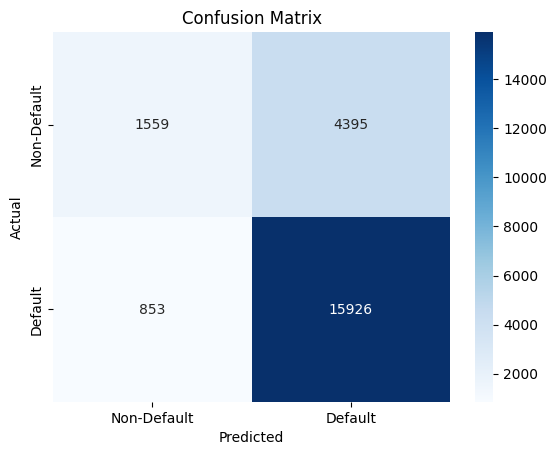

In [5]:

class LoanDefaultModel:
    def __init__(self):
        """
        Initialize the Random Forest model.
        """
        self.model = RandomForestClassifier(random_state=42)

    def load(self, file_path):
        """
        Load the dataset from a specified path.

        Args:
            file_path (str): Path to the Excel file.
        """
        self.data = pd.read_excel(file_path)
        print("Data loaded successfully!")

    def preprocess(self):
        """
        Preprocess the dataset: handle missing values, encode categorical features, and split data.
        """
        print("Starting preprocessing...")

        # Drop rows with missing target values
        self.data.dropna(subset=['loan_status'], inplace=True)

        # Encode 'term' column to numerical values
        self.data['term'] = self.data['term'].str.extract('(\d+)').astype(float)

        # Fill missing numerical values with median
        numerical_columns = ['annual_inc', 'int_rate', 'cibil_score', 'account_bal']
        for col in numerical_columns:
            self.data[col].fillna(self.data[col].median(), inplace=True)

        # Fill missing categorical values with mode
        categorical_columns = ['home_ownership', 'sub_grade', 'purpose']
        for col in categorical_columns:
            self.data[col].fillna(self.data[col].mode()[0], inplace=True)

        # Encode categorical variables
        le = LabelEncoder()
        for col in ['home_ownership', 'sub_grade', 'purpose', 'application_type']:
            self.data[col] = le.fit_transform(self.data[col])

        # Feature Engineering: Add a new feature (Debt-to-Income Ratio)
        self.data['debt_to_income'] = self.data['loan_amnt'] / (self.data['annual_inc'] + 1)

        # Remove outliers for 'loan_amnt' using the 99th percentile
        loan_amnt_99 = self.data['loan_amnt'].quantile(0.99)
        self.data = self.data[self.data['loan_amnt'] <= loan_amnt_99]

        # Select features and target
        self.X = self.data.drop(columns=['loan_status', 'customer_id', 'transaction_date', 'verification_status'])
        self.y = self.data['loan_status']

        # Split the data into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

        # Standardize numerical features
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

        print("Preprocessing completed successfully!")

    def train(self):
        """
        Train the Random Forest model using GridSearchCV for hyperparameter tuning.
        """
        print("Starting model training with hyperparameter tuning...")

        param_grid = {
            'n_estimators': [50, 100],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
        }

        grid_search = GridSearchCV(self.model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(self.X_train, self.y_train)

        self.model = grid_search.best_estimator_
        print("Best Parameters:", grid_search.best_params_)
        print("Model training completed!")

    def test(self):
        """
        Evaluate the model on the test dataset and print evaluation metrics.
        """
        predictions = self.model.predict(self.X_test)
        acc = accuracy_score(self.y_test, predictions)
        auc = roc_auc_score(self.y_test, predictions)

        print(f"\nAccuracy: {acc:.4f} ({acc * 100:.2f}%)")
        print(f"ROC-AUC Score: {auc:.2f}")
        print("\nClassification Report:")
        print(classification_report(self.y_test, predictions))

        # Confusion Matrix
        cm = confusion_matrix(self.y_test, predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def predict(self, new_data):
        """
        Predict the loan status for new data.

        Args:
            new_data (DataFrame): A pandas DataFrame containing the new data.

        Returns:
            ndarray: Predicted loan status (0 or 1).
        """
        return self.model.predict(new_data)

print("----- Running Random Forest Model -----\n")
rf_model = LoanDefaultModel()
rf_model.load('/content/drive/MyDrive/DSW/train_data.xlsx')
rf_model.preprocess()
rf_model.train()
rf_model.test()


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
